# PINN Implementation

This notebook implements PINNs from Raissi et al. 2017. Specifically, the notebook implements Data-Driven Solutions of Nonlinear Partial Differential Equations from https://github.com/maziarraissi/PINNs. The implementation is not the same as Raissi as the original PINN was implemented in Tensorflow v1. Here, we use the TF2 API where the main mechanisms of the PINN arise in the train_step function efficiently computing higher order derivatives of custom loss functions through the use of the GradientTape data structure.

In [2]:
# Imports
import numpy as np
import scipy.io
import tensorflow as tf

from pyDOE import lhs

import matplotlib
import matplotlib.pyplot as plt

tf.config.list_physical_devices(device_type=None)

2022-08-30 11:59:31.089323: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-30 11:59:31.089393: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: gpu-0008
2022-08-30 11:59:31.089402: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: gpu-0008
2022-08-30 11:59:31.089531: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.43.4
2022-08-30 11:59:31.089571: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.43.4
2022-08-30 11:59:31.089577: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.43.4


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Load the Data

The data was gathered from https://github.com/maziarraissi/PINNs/tree/master/main/Data. 

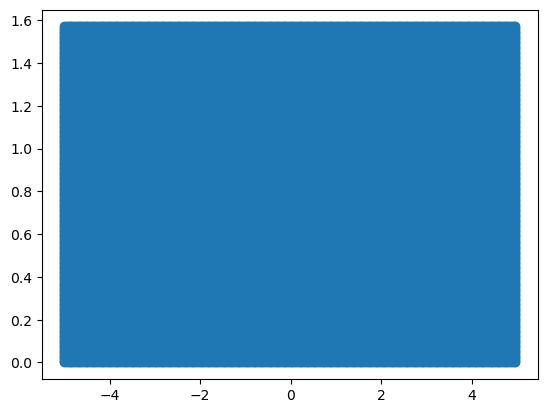

In [24]:
# Linnea: Commented out  because never used
# noise = 0.0        

# Domain bounds
lb = np.array([-5.0, 0.0]) # (x, t)
ub = np.array([5.0, np.pi/2]) # (x, t)

# Assign number of data points
# Linnea: Commented this all out because it is not used. Copied over from Github original
# N0 = 50 # number of initial data points
# N_b = 50 # number of boundary data points
# N_f = 20000 # number of collocation data points
# layers = [2, 100, 100, 100, 100, 2]

# Load data from NLS.mat
# Note: this is the data used to compare the neural network to for losses.
data = scipy.io.loadmat('./NLS.mat')

t = data['tt'].flatten()[:,None] # time data
x = data['x'].flatten()[:,None] # position data
Exact = data['uu'] 

Exact_u = np.real(Exact) # real
Exact_v = np.imag(Exact) # imaginary
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

X, T = np.meshgrid(x,t)

# Flatten and transpose data for ML
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Linnea: Commented this all out because it is not used. Copied over from Github original
# u_star = Exact_u.T.flatten()[:,None]
# v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]

###########################
# Linnea: Commented this all out because it is not used. Copied over from Github original
# # Get initial condition data
# idx_x = np.random.choice(x.shape[0], N0, replace=False)
# x0 = x[idx_x,:]
# u0 = Exact_u[idx_x,0:1]
# v0 = Exact_v[idx_x,0:1]

# # Get boundary data
# idx_t = np.random.choice(t.shape[0], N_b, replace=False)
# tb = t[idx_t,:]

# # Get PINN data
# X_f = lb + (ub-lb)*lhs(2, N_f)

# # model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub)

# plt.imshow(Exact_h)
# plt.plot(x, Exact_h[:, 0])

## PINN Class

The PINN class subclasses the Keras Model so that we can implement our custom fit and train_step functions.

Michael advises working through the TF2 API introduction to Gradients and Autodifferentiation in tensorflow https://www.tensorflow.org/guide/autodiff and Advanced Autodifferentiation in tensorflow https://www.tensorflow.org/guide/advanced_autodiff. These are the main data structures for the PINN used in the train_step function.

In [19]:
'''
Description: Defines the class for a PINN model implementing train_step, fit, and predict functions. Note, it is necessary 
to design each PINN seperately for each system of PDEs since the train_step is customized for a specific system. 
This PINN in particular solves Schrodingers equations. Once trained, the PINN can predict the solution space given 
domain bounds and the input space. 
'''
class PINN(tf.keras.Model):
    def __init__(self, inputs, outputs, lower_bound, upper_bound, x, t, initial_u, initial_v, n_samples=20000, n_initial=50):
        super(PINN, self).__init__(inputs=inputs, outputs=outputs)
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.x = x
        self.t = t
        self.initial_u = initial_u
        self.initial_v = initial_v
        self.n_samples = n_samples
        self.n_initial = n_initial
        
    '''
    Description: A system of PDEs are determined by 3 types of equations: the main partial differential equations, the 
    initial value equations, and the boundary value equations. These three equations will serve as loss functions which 
    we train the PINN to satisfy. If a PINN can satisfy ALL 3 equations, the system is solved. Since there are 3 types of 
    equations (PDE, Initial Value, Boundary Value), we will need 3 types of inputs. Each input is composed of a spatial 
    variable 'x' and a time variable 't'. The different types of (x, t) pairs are described below.
    
    Inputs: 
        x, t: (batchsize, 1) shaped arrays : These inputs are used to derive the main partial differential equation loss.
        Train step first feeds (x, t) through the PINN for the forward propagation. This expression is PINN(x, t) = (u, v). 
        Next, the partials u_x, v_x, u_t, and v_t are obtained. We also need u_xx and v_xx. We utilize TF2s GradientTape
        data structure to obtain all partials. Once we obtain these partials, we can compute the main PDE loss 
        and optimize weights wrt. to the loss. 
        
        x_initial, t_initial : (initial_batchsize, 1) shaped arrays : These inputs are used to derive the initial value
        equations. The initial value loss relies on target data (**not an equation**), so we can just measure the MSE of 
        PINN(x_initial, t_initial) = (u_pred_initial, v_pred_initial) and (u_initial, v_initial).
        
        u_initial, v_initial: (initial_batchsize, 1) shaped arrays : These are the target data for the initial value inputs
        
        x_lower, x_upper, t_boundary: (boundary_batchsize, 1) shaped arrays: These are simply (batchsize, 1) arrays where 
        x values are spatial boundaries and t values span the entire temporal domain. The boundary value equation specifies 
        that the boundaries are symmetric. That is, PINN(x_lowerbound, t) = PINN(x_upperbound, t) AND 
        PINN_x(x_lowerbound, t) = PINN_x(x_upperbound, t).
        
    Outputs: None
    '''
    def train_step(self, x, t, x_initial, t_initial, u_initial, v_initial, x_lower, x_upper, t_boundary):
        with tf.GradientTape(persistent=True) as t3: 
            with tf.GradientTape(persistent=True) as t2: 
                with tf.GradientTape(persistent=True) as t1: 
                    # Forward pass X (PINN data)
                    X = tf.concat((x, t), axis=1)
                    pred = self.tf_call(X)
                    u, v = tf.split(pred, 2, axis=1)
                    
                    # Forward pass X_initial (initial condition data)
                    X_initial = tf.concat((x_initial, t_initial), axis=1)
                    u_pred_initial, v_pred_initial = tf.split(self.tf_call(X_initial), 2, axis=1)
                    
                    # Calculate initial condition loss
                    u_initial_loss = tf.math.reduce_mean(tf.math.square(u_pred_initial - u_initial))
                    v_initial_loss = tf.math.reduce_mean(tf.math.square(v_pred_initial - v_initial))
                    initial_loss = u_initial_loss + v_initial_loss
                    
                    # Forward pass X_lower and X_upper (boundary data)
                    X_lower = tf.concat((x_lower, t_boundary), axis=1)
                    X_upper = tf.concat((x_upper, t_boundary), axis=1)
                    u_lower, v_lower = tf.split(self.tf_call(X_lower), 2, axis=1) 
                    u_upper, v_upper = tf.split(self.tf_call(X_upper), 2, axis=1)
                    
                    # Calculate Boundary loss
                    boundary_u_loss = tf.math.reduce_mean(tf.math.square(u_lower - u_upper))
                    boundary_v_loss = tf.math.reduce_mean(tf.math.square(v_lower - v_upper))
                    boundary_loss = boundary_u_loss + boundary_v_loss
                
                # Calculate first-order PINN gradients
                u_x = t1.gradient(u, x)
                v_x = t1.gradient(v, x)
                u_t = t1.gradient(u, t)
                v_t = t1.gradient(v, t)
                
                # Calculate first-order boundary gradients
                u_x_lower = t1.gradient(u_lower, x_lower)
                u_x_upper = t1.gradient(u_upper, x_upper)
                v_x_lower = t1.gradient(v_lower, x_lower)
                v_x_upper = t1.gradient(v_upper, x_upper)

                # Calculate resulting boundary loss
                boundary_ux_loss = tf.math.reduce_mean(tf.math.square(u_x_lower - u_x_upper))
                boundary_vx_loss = tf.math.reduce_mean(tf.math.square(v_x_lower - v_x_upper))
                boundary_x_loss = boundary_ux_loss + boundary_vx_loss
            
            # Calculate second-order PINN gradients
            u_xx = t2.gradient(u_x, x)
            v_xx = t2.gradient(v_x, x)
            
            # Calculate resulting loss = PINN loss + boundary loss + initial loss (see Raissi et al. equations)
            pinn_loss = self.pinn_loss(u, u_t, u_xx, v, v_t, v_xx)
            total_loss = pinn_loss + (boundary_x_loss + boundary_loss) + initial_loss
        
        # Backpropagate overall gradients of the model loss to all variables
        gradients = t3.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # Return losses
        return total_loss.numpy(), pinn_loss.numpy(), initial_loss.numpy(), (boundary_loss + boundary_x_loss).numpy()
    
    '''
    Description: The fit function used to iterate through epoch * steps_per_epoch steps of train_step. 
    
    Inputs: 
        predict_X: (N, 2) array: Input data for entire spatial and temporal domain. Used for vizualization for
        predictions at the end of each epoch. Michael created a very pretty video file with it. 
        
        batchsize: batchsize for (x, t) in train step
        
        initial_batchsize: batchsize for (x_initial, t_initial) in train step
        
        boundary_batchsize: batchsize for (x_lower, t_boundary) and (x_upper, t_boundary) in train step
        
        epochs: epochs
    
    Outputs: Losses for each equation (PDE, Initial Value, Boundary Value), and predictions for each epoch.
    '''
    def fit(self, predict_X, batchsize=64, initial_batchsize=16, boundary_batchsize=16, epochs=20):
        # Initialize losses as zeros
        steps_per_epoch = np.ceil(self.n_samples / batchsize).astype(int)
        total_pinn_loss = np.zeros((epochs, ))
        total_boundary_loss = np.zeros((epochs, ))
        total_initial_loss = np.zeros((epochs, ))
        total_predictions = np.zeros((51456, 1, epochs))
        
        # For each epoch, sample new values in the PINN, initial, and boundary areas and run them through the train step
        for epoch in range(epochs):
            # Reset loss variables
            pinn_loss = np.zeros((steps_per_epoch,))
            boundary_loss = np.zeros((steps_per_epoch,))
            initial_loss = np.zeros((steps_per_epoch,))
            
            # For each step, get PINN variables, boundary variables, and initial condition variables, and run variables through the train_step
            for step in range(steps_per_epoch):
                # Get PINN x and t variables via uniform distribution sampling between lower and upper bounds
                # Note: original uses latin hypercube sampling
                x = tf.Variable(tf.random.uniform((batchsize, 1), minval=self.lower_bound[0], maxval=self.upper_bound[0]))
                t = tf.Variable(tf.random.uniform((batchsize, 1), minval=self.lower_bound[1], maxval=self.upper_bound[1]))
#                 x, t = tf.split(np.array(self.lower_bound + (self.upper_bound - self.lower_bound)*lhs(2, batchsize), dtype='f'), 2, axis=1)
#                 x = tf.Variable(x, dtype=tf.float32)
#                 t = tf.Variable(t, dtype=tf.float32)
                
                # Get boundary x_lower, x_upper, and t variables by uniformly sampling data along the lower and upper boundaries
                lower_bound = np.zeros((boundary_batchsize, 1))
                upper_bound = np.zeros((boundary_batchsize, 1))
                lower_bound[:] = self.lower_bound[0]
                upper_bound[:] = self.upper_bound[0]
                x_lower = tf.Variable(lower_bound, dtype=tf.float32)
                x_upper = tf.Variable(upper_bound, dtype=tf.float32)
                t_boundary = tf.Variable(tf.random.uniform((boundary_batchsize, 1), minval=self.lower_bound[1], maxval=self.upper_bound[1]))
                
                # Get initial x_initial, t_initial, u_initial, and v_initial variables by randomly sampling along t=0
                x_idx = np.expand_dims(np.random.choice(self.initial_u.shape[0], initial_batchsize, replace=False), axis=1)
                x_initial = self.x[x_idx]
                t_initial = np.zeros((initial_batchsize, 1))
                u_initial = self.initial_u[x_idx]
                v_initial = self.initial_v[x_idx]
                
                # Pass variables through the model via train_step, and get losses
                total_loss = self.train_step(x, t, x_initial, t_initial, u_initial, v_initial, x_lower, x_upper, t_boundary)
                pinn_loss[step] = total_loss[1]
                initial_loss[step] = total_loss[2]
                boundary_loss[step] = total_loss[3]
            
            # Calculate and print total losses for the epoch
            total_pinn_loss[epoch] = np.sum(pinn_loss)
            total_boundary_loss[epoch] = np.sum(boundary_loss)
            total_initial_loss[epoch] = np.sum(initial_loss)
            print(f'Training loss for epoch {epoch}: pinn: {total_pinn_loss[epoch]:.4f}, boundary: {total_boundary_loss[epoch]:.4f}, initial: {total_initial_loss[epoch]:.4f}')
            
            # Get prediction variable loss by the predict function (below)
            total_predictions[:, :, epoch] = np.expand_dims(self.predict(predict_X)[1], axis=1)
        
        # Return epoch losses
        return total_pinn_loss, total_boundary_loss, total_initial_loss, total_predictions
    
    # Predict for some X's the value of the neural network h(x, t), where h = [u, v]
    def predict(self, X, batchsize=2048):
        steps_per_epoch = np.ceil(X.shape[0] / batchsize).astype(int)
        preds = np.zeros((X.shape[0], 2))
        
        # For each step calculate start and end index values for prediction data
        for step in range(steps_per_epoch):
            start_idx = step * 64
            
            # If last step of the epoch, end_idx is shape-1. Else, end_idx is start_idx + 64 
            if step == steps_per_epoch - 1:
                end_idx = X.shape[0] - 1
            else:
                end_idx = start_idx + 64
                
            # Get prediction data and calculate h
            preds[start_idx: end_idx, :] = self(X[start_idx: end_idx, :]).numpy()
        
        h = np.sqrt(preds[:, 0]**2 + preds[:, 1]**2)
        
        # Return prediction data and h
        return preds, h
    
    def evaluate(self, ): 
        pass
    
    # pinn_loss calculates the PINN loss by using the PINN function in Raissi et al. and separating real and imag data
    @tf.function
    def pinn_loss(self, u, u_t, u_xx, v, v_t, v_xx): 
        l_u = tf.math.reduce_mean(tf.math.square(u_t + 0.5 * v_xx + (u**2 + v**2) * v))
        l_v = tf.math.reduce_mean(tf.math.square(v_t - 0.5 * u_xx - (u**2 + v**2) * u))
        
        return l_u + l_v
    
    # tf_call passes inputs through the neural network
    @tf.function
    def tf_call(self, inputs): 
        return self.call(inputs, training=True)

In [20]:
# Define neural network as 6 layers (4 hidden), with activation functions of tanh for hidden layers and linear for the output layer
inputs = tf.keras.Input((2))
x_ = tf.keras.layers.Dense(100, activation='tanh')(inputs)
x_ = tf.keras.layers.Dense(100, activation='tanh')(x_)
x_ = tf.keras.layers.Dense(100, activation='tanh')(x_)
x_ = tf.keras.layers.Dense(100, activation='tanh')(x_)
outputs = tf.keras.layers.Dense(2, activation='linear')(x_) # Note: 2 outputs u & v where h=(u, v)

# Linnea: commented out because it is duplicated above
# # Initialize upper and lower bound data
# lb = np.array([-5.0, 0.0])
# ub = np.array([5.0, np.pi/2])

# Get keras Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

# Define the PINN using the model defined above
pinn = PINN(inputs=inputs, outputs=outputs, lower_bound=lb, upper_bound=ub, 
            x=x[:,0], t=t[:, 0], initial_u=Exact_u[:, 0], initial_v=Exact_v[:, 0])

# Compile the PINN and get loss and prediction outputs
pinn.compile(optimizer="adam")
pinn_loss, boundary_loss, initial_loss, predictions = pinn.fit(predict_X=X_star, batchsize=2048, 
                                               initial_batchsize=64, boundary_batchsize=32, epochs=3)

Training loss for epoch 0: pinn: 0.0499, boundary: 5.9369, initial: 7.4406
Training loss for epoch 1: pinn: 0.0959, boundary: 1.2661, initial: 3.8575
Training loss for epoch 2: pinn: 0.1252, boundary: 0.4844, initial: 2.9477


In [21]:
import pickle as pkl

# Save loss data, prediction data, and h-function approximation
with open('./figures/pinn_loss.pkl', 'wb') as file:
    pkl.dump(pinn_loss, file)
    
with open('./figures/boundary_loss.pkl', 'wb') as file:
    pkl.dump(boundary_loss, file)
    
with open('./figures/initial_loss.pkl', 'wb') as file:
    pkl.dump(initial_loss, file)
    
with open('./figures/predictions.pkl', 'wb') as file:
    pkl.dump(predictions, file)
    
with open('./figures/true.pkl', 'wb') as file:
    pkl.dump(h_star, file)